# Solving Street View House Numbers using CNN

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Importing all necessary packages 

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
import scipy.io as sio

'''SEED = 123                 # to be able to rerun the same NN
np.random.seed(SEED)
tf.random.set_seed(SEED)

'''

np.set_printoptions(precision=4, suppress=True, floatmode='fixed') # options determine the way floating point numbers

%matplotlib inline

Using TensorFlow backend.


loading data and defining classes

In [0]:
train_data = sio.loadmat('/content/drive/My Drive/Colab Notebooks/SHVN_using_CNN/dataset/train_32x32.mat')
test_data = sio.loadmat('/content/drive/My Drive/Colab Notebooks/SHVN_using_CNN/dataset/test_32x32.mat')
extra_data = sio.loadmat('/content/drive/My Drive/Colab Notebooks/SHVN_using_CNN/dataset/extra_32x32.mat')

X_train, y_train = train_data['X'], train_data['y']
X_test, y_test = test_data['X'], test_data['y']
X_extra, y_extra = extra_data['X'], extra_data['y']

classes = [0,1,2,3,4,5,6,7,8,9]
nb_classes = 10

print(X_train.shape, X_test.shape, X_extra.shape)

(32, 32, 3, 73257) (32, 32, 3, 26032) (32, 32, 3, 531131)


Working on data

In [0]:

# Transpose the image arrays
X_train, y_train = np.transpose(X_train,(3,0,1,2)), y_train[:,0]
X_test, y_test = np.transpose(X_test,(3,0,1,2)), y_test[:,0]
X_extra, y_extra = np.transpose(X_extra,(3,0,1,2)), y_extra[:,0]


# Merge train and extra data
X_train = np.concatenate([X_train, X_extra])
y_train = np.concatenate([y_train, y_extra])

# Normalize
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255


# print  shapes
print("Training Set", X_train.shape)
print("Test Set", X_test.shape)
print('')

# Calculate the total number of images
num_images = X_train.shape[0] + X_test.shape[0]
print("Total Number of Images", num_images)

Training Set (604388, 32, 32, 3)
Test Set (26032, 32, 32, 3)

Total Number of Images 630420


Quick visualization 

In [0]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [0]:

print(y_train[:4])
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train[:4]

[1 9 2 3]


array([[0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000],
       [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000],
       [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000],
       [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000]], dtype=float32)

Label 6331 is [0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]


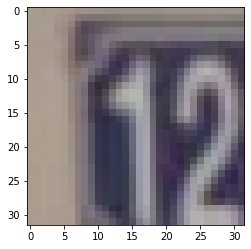

In [0]:
i = np.random.randint(1, len(X_train))
print("Label %d is" % i, y_train[i])
plt.imshow(X_train[i])

Building the model :
INPUT -> [CONV -> RELU -> POOL -> CONV -> RELU] -> FC -> softmax

In [0]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=X_train[0].shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(5, 5), activation='relu'))
model.add(Flatten())          #flatten since too many dimensions, we only want a classification output
model.add(Dense(256))
model.add(Dropout(0.2))
model.add(Dense(len(y_train[0]), activation='softmax'))       #output a softmax to squash the matrix into output probabilities

model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

a summary of the model

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 64)        4864      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 128)       204928    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 1, 256)         819456    
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

and now training the model

In [0]:
model_history = model.fit(X_train, y_train, batch_size=128, epochs=15, validation_split = 0.1)

Train on 543949 samples, validate on 60439 samples
Epoch 1/15
543949/543949 [==============================] - 120s 221us/step - loss: 0.2001 - acc: 0.9435 - val_loss: 0.1059 - val_acc: 0.9693
Epoch 2/15
543949/543949 [==============================] - 120s 220us/step - loss: 0.1152 - acc: 0.9686 - val_loss: 0.0931 - val_acc: 0.9749
Epoch 3/15
543949/543949 [==============================] - 120s 221us/step - loss: 0.0929 - acc: 0.9754 - val_loss: 0.0765 - val_acc: 0.9797
Epoch 4/15
543949/543949 [==============================] - 120s 221us/step - loss: 0.0790 - acc: 0.9795 - val_loss: 0.0757 - val_acc: 0.9806
Epoch 5/15
543949/543949 [==============================] - 120s 220us/step - loss: 0.0681 - acc: 0.9827 - val_loss: 0.0814 - val_acc: 0.9799
Epoch 6/15
543949/543949 [==============================] - 120s 220us/step - loss: 0.0593 - acc: 0.9852 - val_loss: 0.0789 - val_acc: 0.9819
Epoch 7/15
543949/543949 [==============================] - 120s 220us/step - loss: 0.0521 - acc:

Evaluating the model by printing the test score and test accuracy

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0]) #loss
print('Test accuracy:', score[1])

Test score: 0.36991916027256794
Test accuracy: 0.947180393362016


Visualize the prediction

In [0]:
res_test = model.predict(X_test)

In [0]:
# plotting Correctly classified results
res_test = pd.DataFrame({'true':np.argmax(y_test, axis=1), 'predict':np.argmax(res_test, axis=1), 'proba':np.max(res_test, axis=1)})
res_test.head(10)

,true,predict,proba
0,5,5,0.999961
1,2,2,1.000000
2,1,1,1.000000
3,0,0,1.000000
4,6,6,0.997285
5,1,1,0.991656
6,9,9,0.999999
7,1,1,1.000000
8,1,1,1.000000
9,8,8,1.000000


In [0]:
# plotting Misclassified results
errors = res_test[res_test.true != res_test.predict].sort_values('proba', ascending=False)
errors.head(10)

,true,predict,proba
12581,7,0,1.0
8250,1,5,1.0
8511,2,3,1.0
23832,5,0,1.0
1794,6,1,1.0
8252,5,8,1.0
8251,8,1,1.0
23735,2,7,1.0
21348,5,3,1.0
8108,4,3,1.0


In [0]:
print('Percentage of error %4.2f %%' % (100 * len(errors)/len(X_test))) 

Percentage of error 5.28 %


Prediction 

Image : 1856
The Predicted is 7  
The real is 7
Stats are [[0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000]]


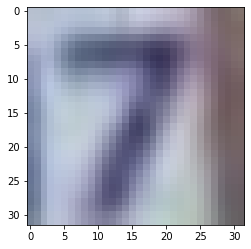

In [0]:
i = 1856
res = model.predict(X_train[i][None,:,:]) 
print("Image :", i)
print(f"The Predicted is {np.argmax(res)}  \nThe real is {np.argmax(y_test[i])}")
print("Stats are", np.array(res))
plt.imshow(X_test[i])

for saving the model

In [0]:
'''model.save('SVHN_models/SVHN_model-2-epochs.h5')'''

Loading saved model

In [0]:
'''import keras
from keras.models import load_model

# Recreate the exact same model purely from the file
new_model = keras.models.load_model('SVHN_models/SVHN_model-5-epochs.h5')'''

In [0]:
'''i = 1856 
res = new_model.predict(X_train[i][None,:,:]) 
print("Image :", i)
print(f"The Predicted is {np.argmax(res)}  \nThe real is {np.argmax(y_test[i])}")
print("Stats are", np.array(res))
plt.imshow(X_test[i])'''